In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Reload the optimization module to get latest changes
import importlib
import optimization
importlib.reload(optimization)

from optimization import (
    load_datasets, average_datasets, TafelData,
    ParticleSwarmOptimizer, MCMCOptimizer,
    compare_optimizers, plot_optimization_results,
    residual_function, objective_function
)
from models import Model

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Imports successful with module reload!")

Imports successful with module reload!


## Load and Process Data

Load all three datasets and create an averaged dataset for parameter fitting.

In [2]:
# Load individual datasets
datasets = load_datasets()

print("Individual datasets loaded:")
for name, data in datasets.items():
    print(f"{name}: {len(data.eta)} data points")
    print(f"  η range: {np.min(data.eta):.2f} to {np.max(data.eta):.2f} V")
    print(f"  ln(k) range: {np.min(data.lnk):.2f} to {np.max(data.lnk):.2f}")
    print()

Individual datasets loaded:
Cell A: 37 data points
  η range: -15.62 to 14.76 V
  ln(k) range: -8.67 to -5.16

Cell B: 40 data points
  η range: -15.53 to 14.51 V
  ln(k) range: -8.79 to -5.11

Cell C: 35 data points
  η range: -15.36 to 14.06 V
  ln(k) range: -8.96 to -5.06



In [3]:
# Create averaged dataset
avg_data = average_datasets(datasets)

print(f"Averaged dataset created:")
print(f"  Data points: {len(avg_data.eta)}")
print(f"  η range: {np.min(avg_data.eta):.2f} to {np.max(avg_data.eta):.2f} V")
print(f"  ln(k) range: {np.min(avg_data.lnk):.2f} to {np.max(avg_data.lnk):.2f}")

# Apply mask to exclude low ln(k) values
mask_threshold = -8.0
mask = avg_data.lnk >= mask_threshold
n_valid = np.sum(mask)
print(f"\nData quality check:")
print(f"  Points with ln(k) ≥ {mask_threshold}: {n_valid}/{len(avg_data.eta)} ({100*n_valid/len(avg_data.eta):.1f}%)")

Averaged dataset created:
  Data points: 100
  η range: -15.62 to 14.76 V
  ln(k) range: -8.75 to -5.12

Data quality check:
  Points with ln(k) ≥ -8.0: 88/100 (88.0%)


## Visualize Raw Data

Plot individual datasets and the averaged data.

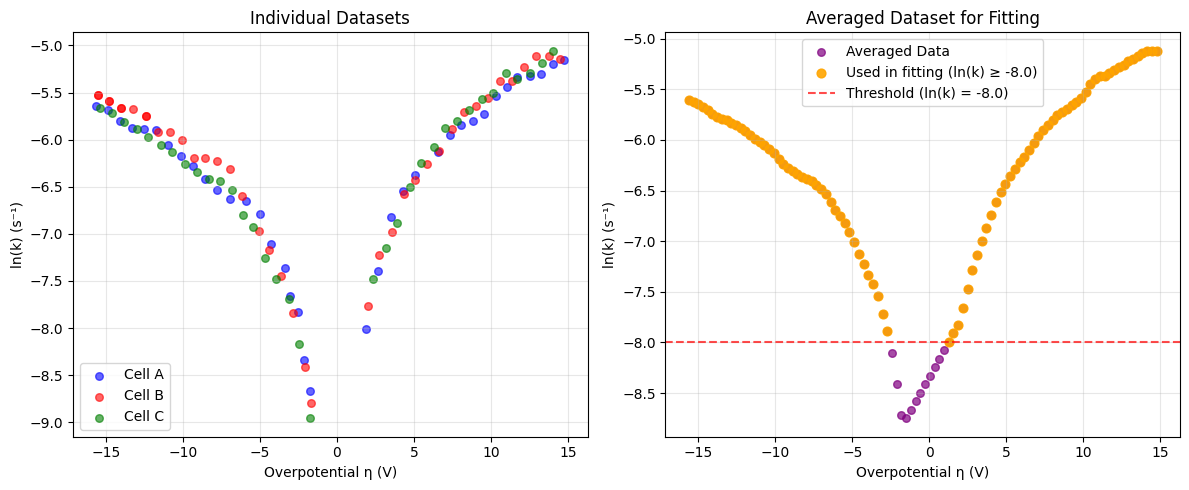

In [4]:
plt.figure(figsize=(12, 5))

# Plot 1: Individual datasets
plt.subplot(1, 2, 1)
colors = ['blue', 'red', 'green']
for i, (name, data) in enumerate(datasets.items()):
    plt.scatter(data.eta, data.lnk, alpha=0.6, label=name, 
               color=colors[i], s=30)

plt.xlabel('Overpotential η (V)')
plt.ylabel('ln(k) (s⁻¹)')
plt.title('Individual Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Averaged dataset
plt.subplot(1, 2, 2)
plt.scatter(avg_data.eta, avg_data.lnk, alpha=0.7, 
           color='purple', s=30, label='Averaged Data')

# Highlight data points that will be used in fitting (above threshold)
mask = avg_data.lnk >= mask_threshold
plt.scatter(avg_data.eta[mask], avg_data.lnk[mask], 
           alpha=0.9, color='orange', s=40, 
           label=f'Used in fitting (ln(k) ≥ {mask_threshold})')

plt.axhline(y=mask_threshold, color='red', linestyle='--', alpha=0.7,
           label=f'Threshold (ln(k) = {mask_threshold})')

plt.xlabel('Overpotential η (V)')
plt.ylabel('ln(k) (s⁻¹)')
plt.title('Averaged Dataset for Fitting')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Diagnostic Check

Before optimization, let's test the MHC model with some reasonable parameter values to ensure everything is working correctly.

Testing MHC model with sample parameters...
Test parameters:
  k01 = 1.000000e-04 s⁻¹
  k02 = 2.000000e-04 s⁻¹
  λ   = 10.000

Model evaluation successful!
  η range: -15.62 to 14.76
  ln(k) range: -12.03 to -4.69
  Residuals: 88 points, RMSE = 0.2483


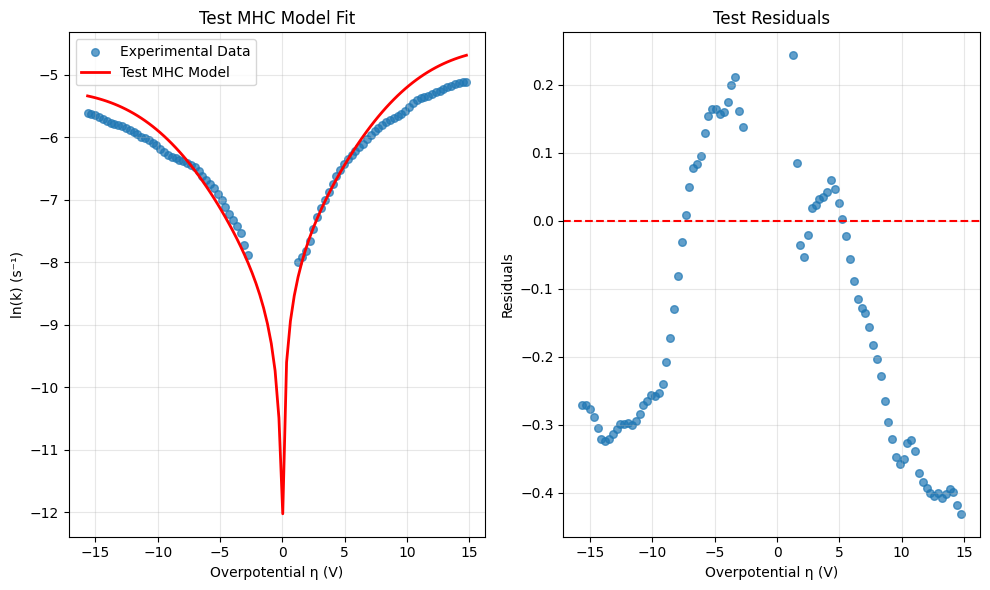

In [5]:
# Test the MHC model with some reasonable parameter values
print("Testing MHC model with sample parameters...")

# Test parameters (reasonable starting values)
k01_test = 1e-4  # s⁻¹
k02_test = 2e-4  # s⁻¹
lambda_test = 10.0  # dimensionless

print(f"Test parameters:")
print(f"  k01 = {k01_test:.6e} s⁻¹")
print(f"  k02 = {k02_test:.6e} s⁻¹")
print(f"  λ   = {lambda_test:.3f}")

# Create test model (MHC - no C parameter)
test_model = Model(model='MHC', k01=k01_test, k02=k02_test, lambda_=lambda_test, 
                  eta=avg_data.eta, origin_eta=True)

try:
    eta_model_test, lnk_model_test = test_model.ln_k()
    
    # Calculate test residuals
    test_params = [k01_test, k02_test, lambda_test]  # MHC: k01, k02, lambda
    residuals_test = residual_function(test_params, avg_data, 'MHC', mask_threshold)
    
    print(f"\nModel evaluation successful!")
    print(f"  η range: {eta_model_test.min():.2f} to {eta_model_test.max():.2f}")
    print(f"  ln(k) range: {lnk_model_test.min():.2f} to {lnk_model_test.max():.2f}")
    print(f"  Residuals: {len(residuals_test)} points, RMSE = {np.sqrt(np.mean(residuals_test**2)):.4f}")
    
    # Quick visualization
    plt.figure(figsize=(10, 6))
    
    mask = avg_data.lnk >= mask_threshold
    plt.subplot(1, 2, 1)
    plt.scatter(avg_data.eta[mask], avg_data.lnk[mask], alpha=0.7, s=30, label='Experimental Data')
    plt.plot(eta_model_test, lnk_model_test, 'r-', linewidth=2, label='Test MHC Model')
    plt.xlabel('Overpotential η (V)')
    plt.ylabel('ln(k) (s⁻¹)')
    plt.title('Test MHC Model Fit')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Residuals
    lnk_pred_test = np.interp(avg_data.eta, eta_model_test, lnk_model_test)
    residuals_plot_test = avg_data.lnk[mask] - lnk_pred_test[mask]
    
    plt.subplot(1, 2, 2)
    plt.scatter(avg_data.eta[mask], residuals_plot_test, alpha=0.7, s=30)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Overpotential η (V)')
    plt.ylabel('Residuals')
    plt.title('Test Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in model evaluation: {e}")
    import traceback
    traceback.print_exc()

In [6]:
# Parameter sensitivity analysis for MHC model
print("\nMHC Parameter Sensitivity Analysis:")
print("="*40)

# Test different parameter combinations
k01_values = [5e-5, 1e-4, 2e-4]
k02_values = [1e-4, 2e-4, 4e-4]
lambda_values = [8.0, 10.0, 12.0]

best_rmse = float('inf')
best_params_test = None

for k01_val in k01_values:
    for k02_val in k02_values:
        for lambda_val in lambda_values:
            test_params = [k01_val, k02_val, lambda_val]
            try:
                residuals = residual_function(test_params, avg_data, 'MHC', mask_threshold)
                rmse = np.sqrt(np.mean(residuals**2))
                print(f"k01={k01_val:.1e}, k02={k02_val:.1e}, λ={lambda_val:.1f}: RMSE={rmse:.4f}")
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params_test = test_params.copy()
                    
            except Exception as e:
                print(f"k01={k01_val:.1e}, k02={k02_val:.1e}, λ={lambda_val:.1f}: ERROR - {e}")

if best_params_test is not None:
    print(f"\nBest test parameters: k01={best_params_test[0]:.6e}, k02={best_params_test[1]:.6e}, λ={best_params_test[2]:.1f}")
    print(f"Best test RMSE: {best_rmse:.4f}")
    
    # Suggested parameter bounds
    print(f"\nSuggested parameter bounds for MHC:")
    print(f"  k01: 1e-6 to 1e-2 s⁻¹")
    print(f"  k02: 1e-6 to 1e-2 s⁻¹")
    print(f"  λ: 6.0 to 15.0 (dimensionless)")
else:
    print("\nERROR: No valid parameter combinations found!")


MHC Parameter Sensitivity Analysis:
k01=5.0e-05, k02=1.0e-04, λ=8.0: RMSE=0.7423
k01=5.0e-05, k02=1.0e-04, λ=10.0: RMSE=0.5763
k01=5.0e-05, k02=1.0e-04, λ=12.0: RMSE=0.5046
k01=5.0e-05, k02=2.0e-04, λ=8.0: RMSE=0.5616
k01=5.0e-05, k02=2.0e-04, λ=10.0: RMSE=0.4699
k01=5.0e-05, k02=2.0e-04, λ=12.0: RMSE=0.4853
k01=5.0e-05, k02=4.0e-04, λ=8.0: RMSE=0.7557
k01=5.0e-05, k02=4.0e-04, λ=10.0: RMSE=0.7752
k01=5.0e-05, k02=4.0e-04, λ=12.0: RMSE=0.8413
k01=1.0e-04, k02=1.0e-04, λ=8.0: RMSE=0.4963
k01=1.0e-04, k02=1.0e-04, λ=10.0: RMSE=0.4159
k01=1.0e-04, k02=1.0e-04, λ=12.0: RMSE=0.4531
k01=1.0e-04, k02=2.0e-04, λ=8.0: RMSE=0.1035
k01=1.0e-04, k02=2.0e-04, λ=10.0: RMSE=0.2483
k01=1.0e-04, k02=2.0e-04, λ=12.0: RMSE=0.4315
k01=1.0e-04, k02=4.0e-04, λ=8.0: RMSE=0.5162
k01=1.0e-04, k02=4.0e-04, λ=10.0: RMSE=0.6646
k01=1.0e-04, k02=4.0e-04, λ=12.0: RMSE=0.8115
k01=2.0e-04, k02=1.0e-04, λ=8.0: RMSE=0.6412
k01=2.0e-04, k02=1.0e-04, λ=10.0: RMSE=0.6952
k01=2.0e-04, k02=1.0e-04, λ=12.0: RMSE=0.7909
k01=

## Parameter Fitting with PSO

Use Particle Swarm Optimization to find optimal MHC model parameters.

In [7]:
# Set up PSO for MHC model
print("Setting up Particle Swarm Optimization for MHC model...")
print("Parameter bounds:")
print("  k01: 1e-6 to 1e-2 s⁻¹")
print("  k02: 1e-6 to 1e-2 s⁻¹") 
print("  λ (dimensionless): 6.0 to 15.0")
print()

# Initialize PSO
pso = ParticleSwarmOptimizer(
    n_particles=30,      # Reasonable number of particles
    n_iterations=100,    # Reasonable number of iterations
    w=0.5,              # Inertia weight
    c1=1.5,             # Cognitive coefficient
    c2=1.5              # Social coefficient
)

# Set bounds for MHC model: k01, k02, lambda
mhc_bounds = [(1e-6, 1e-2), (1e-6, 1e-2), (6.0, 15.0)]  # k01, k02, lambda

# Run PSO optimization
pso_params, pso_cost, pso_history = pso.optimize(
    avg_data, 
    model_type='MHC',
    bounds=mhc_bounds,
    mask_threshold=mask_threshold,
    verbose=True
)

print(f"\nPSO Results:")
print(f"  k01 = {pso_params[0]:.6e} s⁻¹")
print(f"  k02 = {pso_params[1]:.6e} s⁻¹")
print(f"  λ   = {pso_params[2]:.3f} (dimensionless)")
print(f"  Final cost: {pso_cost:.6e}")

# Compare with sensitivity analysis
if best_params_test is not None:
    print(f"\nComparison with sensitivity analysis:")
    print(f"  Sensitivity best: k01={best_params_test[0]:.1e}, k02={best_params_test[1]:.1e}, λ={best_params_test[2]:.1f}, RMSE={best_rmse:.4f}")
    print(f"  PSO result: k01={pso_params[0]:.1e}, k02={pso_params[1]:.1e}, λ={pso_params[2]:.1f}, Cost={pso_cost:.4f}")

Setting up Particle Swarm Optimization for MHC model...
Parameter bounds:
  k01: 1e-6 to 1e-2 s⁻¹
  k02: 1e-6 to 1e-2 s⁻¹
  λ (dimensionless): 6.0 to 15.0

PSO: Initial best cost: 398.630432
PSO: Iteration 20/100, Best cost: 0.413633
PSO: Iteration 40/100, Best cost: 0.412962
PSO: Iteration 60/100, Best cost: 0.412962
PSO: Iteration 80/100, Best cost: 0.412962
PSO: Iteration 100/100, Best cost: 0.412962
PSO: Final best cost: 0.412962

PSO Results:
  k01 = 1.153282e-04 s⁻¹
  k02 = 2.036997e-04 s⁻¹
  λ   = 7.688 (dimensionless)
  Final cost: 4.129619e-01

Comparison with sensitivity analysis:
  Sensitivity best: k01=1.0e-04, k02=2.0e-04, λ=8.0, RMSE=0.1035
  PSO result: k01=1.2e-04, k02=2.0e-04, λ=7.7, Cost=0.4130
PSO: Iteration 60/100, Best cost: 0.412962
PSO: Iteration 80/100, Best cost: 0.412962
PSO: Iteration 100/100, Best cost: 0.412962
PSO: Final best cost: 0.412962

PSO Results:
  k01 = 1.153282e-04 s⁻¹
  k02 = 2.036997e-04 s⁻¹
  λ   = 7.688 (dimensionless)
  Final cost: 4.129619e

## Parameter Fitting with MCMC

Use Markov Chain Monte Carlo for Bayesian parameter estimation, starting from PSO results.

In [8]:
# Set up MCMC for MHC model
print("Setting up Markov Chain Monte Carlo for MHC model...")
print("Using PSO result as starting point for MCMC")
print()

# Initialize MCMC
mcmc = MCMCOptimizer(
    n_samples=5000,     # Total samples
    burn_in=1000,       # Burn-in samples to discard
    proposal_std=None   # Will be auto-set to 1% of parameter ranges
)

# Run MCMC optimization
mcmc_params, mcmc_samples, mcmc_history = mcmc.optimize(
    avg_data,
    model_type='MHC',
    initial_params=pso_params,  # Start from PSO result
    mask_threshold=mask_threshold,
    sigma=0.5,  # Assumed measurement error
    verbose=True
)

mcmc_cost = objective_function(mcmc_params, avg_data, 'MHC', mask_threshold)

print(f"\nMCMC Results (MAP estimate):")
print(f"  k01 = {mcmc_params[0]:.6e} s⁻¹")
print(f"  k02 = {mcmc_params[1]:.6e} s⁻¹")
print(f"  λ   = {mcmc_params[2]:.3f} (dimensionless)")
print(f"  Final cost: {mcmc_cost:.6e}")
print(f"  MCMC samples collected: {len(mcmc_samples)}")

Setting up Markov Chain Monte Carlo for MHC model...
Using PSO result as starting point for MCMC

MCMC: Starting with log-posterior: -20.70
MCMC: Sample 1000/5000, Acceptance rate: 0.030, Log-posterior: -21.06
MCMC: Sample 2000/5000, Acceptance rate: 0.024, Log-posterior: -22.19
MCMC: Sample 3000/5000, Acceptance rate: 0.023, Log-posterior: -21.75
MCMC: Sample 4000/5000, Acceptance rate: 0.027, Log-posterior: -21.92
MCMC: Sample 5000/5000, Acceptance rate: 0.025, Log-posterior: -22.14
MCMC: Final acceptance rate: 0.025
MCMC: MAP estimate found

MCMC Results (MAP estimate):
  k01 = 1.202230e-04 s⁻¹
  k02 = 2.125008e-04 s⁻¹
  λ   = 7.593 (dimensionless)
  Final cost: 5.015687e-01
  MCMC samples collected: 4000
MCMC: Sample 3000/5000, Acceptance rate: 0.023, Log-posterior: -21.75
MCMC: Sample 4000/5000, Acceptance rate: 0.027, Log-posterior: -21.92
MCMC: Sample 5000/5000, Acceptance rate: 0.025, Log-posterior: -22.14
MCMC: Final acceptance rate: 0.025
MCMC: MAP estimate found

MCMC Result

## Statistical Analysis of MCMC Results

Analyze parameter uncertainties and correlations from MCMC samples.

In [9]:
# Calculate statistics from MCMC samples
param_names = ['k01', 'k02', 'λ']
param_units = ['s⁻¹', 's⁻¹', 'dimensionless']

print("MCMC Parameter Statistics:")
print("=" * 50)

means = np.mean(mcmc_samples, axis=0)
stds = np.std(mcmc_samples, axis=0)
percentiles = np.percentile(mcmc_samples, [2.5, 25, 50, 75, 97.5], axis=0)

for i, (name, unit) in enumerate(zip(param_names, param_units)):
    print(f"\n{name} ({unit}):")
    print(f"  MAP estimate:  {mcmc_params[i]:.6e}")
    print(f"  Mean ± Std:    {means[i]:.6e} ± {stds[i]:.6e}")
    print(f"  Median:        {percentiles[2, i]:.6e}")
    print(f"  95% CI:        [{percentiles[0, i]:.6e}, {percentiles[4, i]:.6e}]")
    print(f"  IQR:           [{percentiles[1, i]:.6e}, {percentiles[3, i]:.6e}]")

# Calculate parameter correlations
correlation_matrix = np.corrcoef(mcmc_samples.T)
print(f"\nParameter Correlations:")
print("  ", end="")
for name in param_names:
    print(f"{name:>8}", end="")
print()
for i, name in enumerate(param_names):
    print(f"{name:>3}", end="")
    for j in range(len(param_names)):
        print(f"{correlation_matrix[i, j]:8.3f}", end="")
    print()

MCMC Parameter Statistics:

k01 (s⁻¹):
  MAP estimate:  1.202230e-04
  Mean ± Std:    1.198307e-04 ± 1.275054e-05
  Median:        1.202230e-04
  95% CI:        [9.636163e-05, 1.412254e-04]
  IQR:           [1.097140e-04, 1.299470e-04]

k02 (s⁻¹):
  MAP estimate:  2.125008e-04
  Mean ± Std:    2.161400e-04 ± 1.607054e-05
  Median:        2.175325e-04
  95% CI:        [1.849776e-04, 2.435689e-04]
  IQR:           [2.051217e-04, 2.273210e-04]

λ (dimensionless):
  MAP estimate:  7.592553e+00
  Mean ± Std:    7.423984e+00 ± 4.672238e-01
  Median:        7.469560e+00
  95% CI:        [6.729747e+00, 8.320285e+00]
  IQR:           [7.001303e+00, 7.671716e+00]

Parameter Correlations:
       k01     k02       λ
k01   1.000   0.221  -0.651
k02   0.221   1.000  -0.394
  λ  -0.651  -0.394   1.000


## Visualization of Optimization Results

Plot convergence histories, parameter distributions, and model fits.

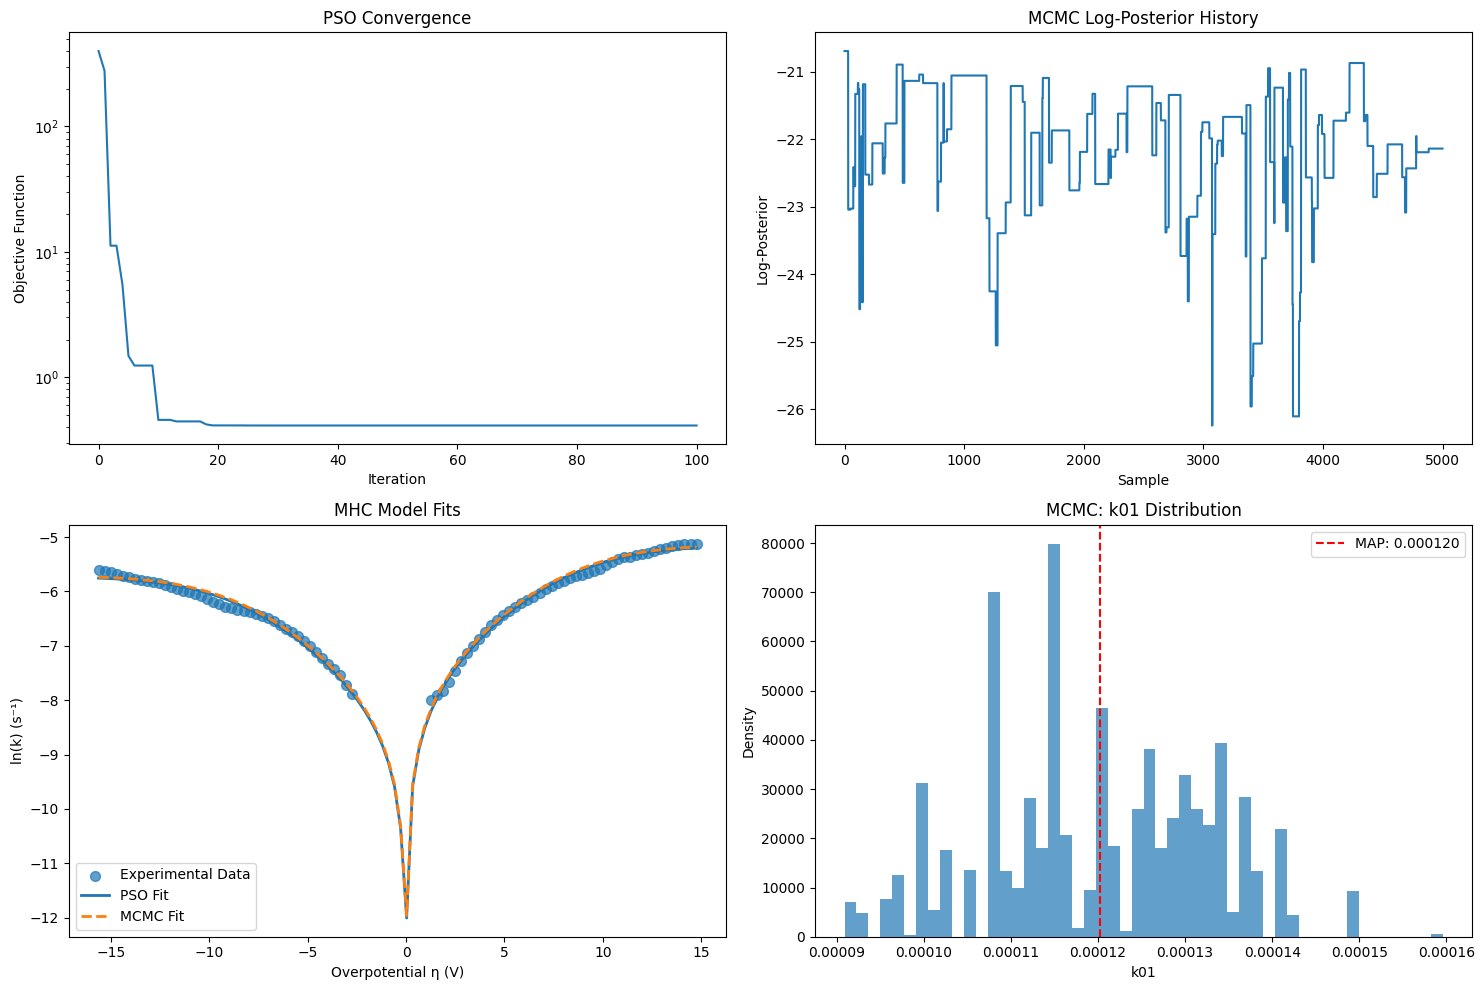

In [10]:
# Create comprehensive results dictionary
results = {
    'pso': {
        'params': pso_params,
        'cost': pso_cost,
        'history': pso_history
    },
    'mcmc': {
        'params': mcmc_params,
        'cost': mcmc_cost,
        'samples': mcmc_samples,
        'history': mcmc_history
    }
}

# Plot optimization results
fig = plot_optimization_results(results, avg_data, 'MHC', mask_threshold)

## Detailed Parameter Distribution Plots

Visualize MCMC parameter distributions and correlations.

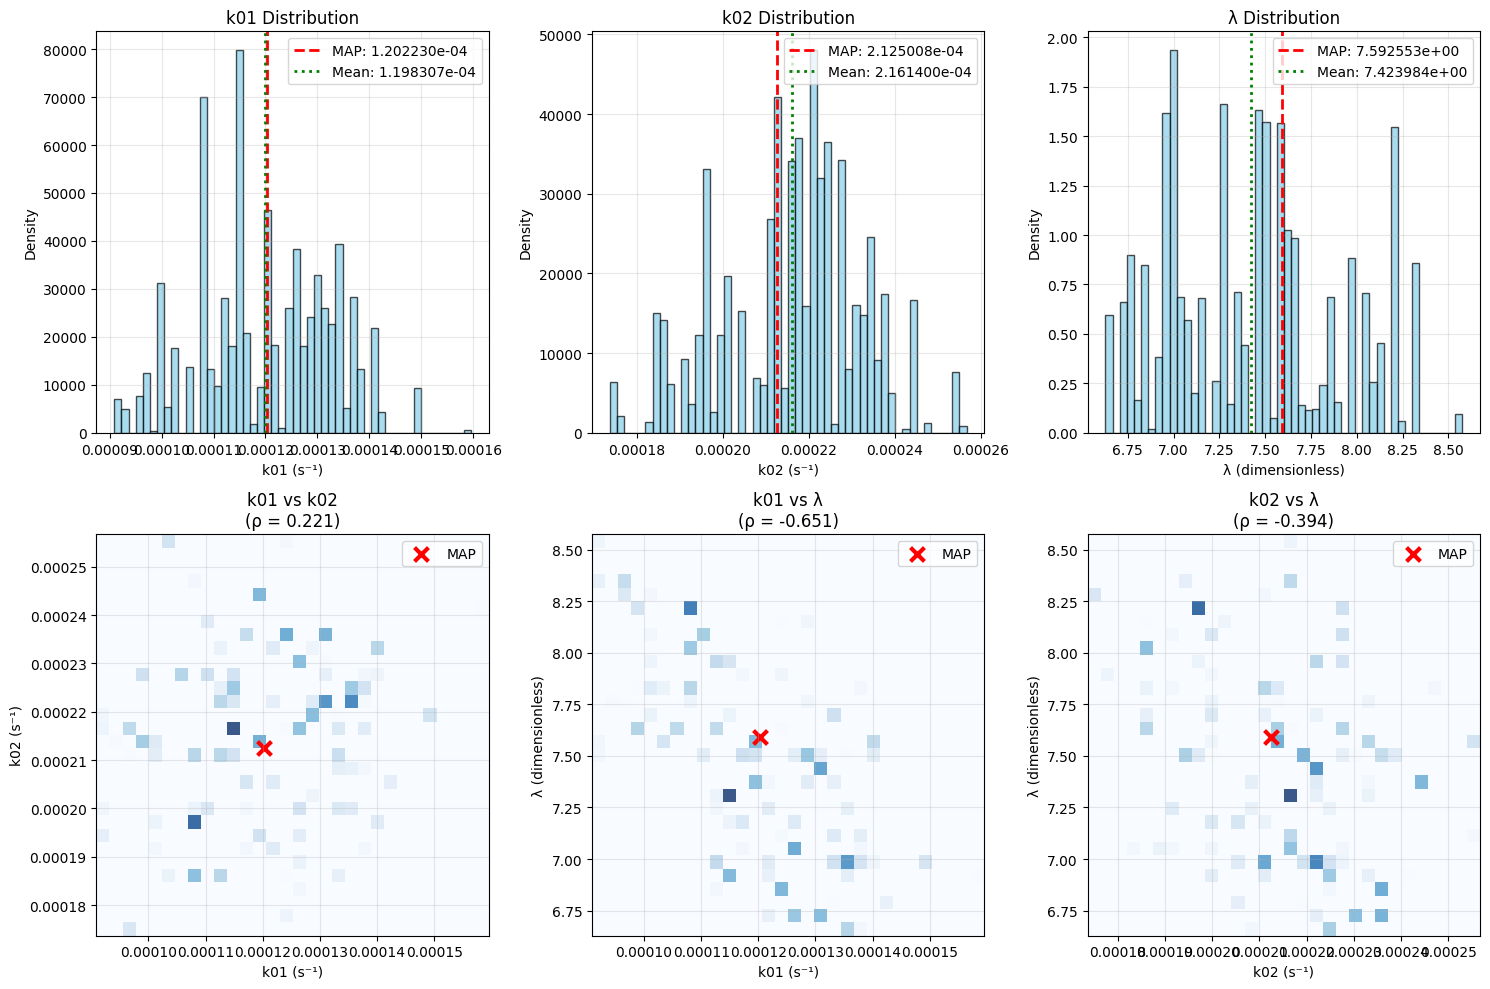

In [11]:
# Plot parameter distributions and correlations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Parameter distributions (top row)
for i, (name, unit) in enumerate(zip(param_names, param_units)):
    ax = axes[0, i]
    
    # Histogram
    ax.hist(mcmc_samples[:, i], bins=50, alpha=0.7, density=True, 
           color='skyblue', edgecolor='black')
    
    # Mark MAP estimate
    ax.axvline(mcmc_params[i], color='red', linestyle='--', linewidth=2,
              label=f'MAP: {mcmc_params[i]:.6e}')
    
    # Mark mean
    ax.axvline(means[i], color='green', linestyle=':', linewidth=2,
              label=f'Mean: {means[i]:.6e}')
    
    ax.set_xlabel(f'{name} ({unit})')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Parameter correlation plots (bottom row)
correlations = [(0, 1), (0, 2), (1, 2)]  # (k01,k02), (k01,λ), (k02,λ)
corr_titles = ['k01 vs k02', 'k01 vs λ', 'k02 vs λ']

for i, ((idx1, idx2), title) in enumerate(zip(correlations, corr_titles)):
    ax = axes[1, i]
    
    # 2D histogram (density plot)
    ax.hist2d(mcmc_samples[:, idx1], mcmc_samples[:, idx2], 
             bins=30, alpha=0.8, cmap='Blues')
    
    # Mark MAP estimate
    ax.scatter(mcmc_params[idx1], mcmc_params[idx2], 
              color='red', s=100, marker='x', linewidth=3,
              label='MAP')
    
    ax.set_xlabel(f'{param_names[idx1]} ({param_units[idx1]})')
    ax.set_ylabel(f'{param_names[idx2]} ({param_units[idx2]})')
    ax.set_title(f'{title}\n(ρ = {correlation_matrix[idx1, idx2]:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Validation and Error Analysis

Calculate detailed error metrics and compare with literature values.

In [12]:
# Calculate detailed error metrics for both optimizers
print("Model Validation and Error Analysis")
print("=" * 50)

methods = [('PSO', pso_params), ('MCMC', mcmc_params)]

for method_name, params in methods:
    print(f"\n{method_name} Results:")
    print("-" * 20)
    
    # Calculate residuals and error metrics
    residuals = residual_function(params, avg_data, 'MHC', mask_threshold)
    
    if len(residuals) > 1:  # Valid residuals
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        max_error = np.max(np.abs(residuals))
        
        print(f"  RMSE:      {rmse:.4f}")
        print(f"  MAE:       {mae:.4f}")
        print(f"  Max Error: {max_error:.4f}")
        print(f"  R²:        {1 - np.var(residuals)/np.var(avg_data.lnk[avg_data.lnk >= mask_threshold]):.4f}")
        
        # Parameter values
        print(f"  Parameters:")
        print(f"    k01 = {params[0]:.3e} s⁻¹")
        print(f"    k02 = {params[1]:.3e} s⁻¹")
        print(f"    λ   = {params[2]:.3f} (dimensionless)")
        
        # Compare with literature (if available)
        literature_lambda = [8.3, 13.5]  # From previous studies
        closest_lit = min(literature_lambda, key=lambda x: abs(x - params[2]))
        print(f"    Closest literature λ: {closest_lit}")
        print(f"    Difference: {params[2] - closest_lit:.2f}")
        
        # k01/k02 ratio analysis
        ratio = params[0] / params[1]
        print(f"    k01/k02 ratio: {ratio:.3f}")
        if abs(ratio - 1.0) < 0.1:
            print(f"    → Nearly symmetric kinetics")
        elif ratio > 1.1:
            print(f"    → Oxidation favored")
        else:
            print(f"    → Reduction favored")
    else:
        print(f"  ERROR: No valid residuals calculated")

# Summary comparison
print(f"\nMethod Comparison:")
print("-" * 20)
print(f"PSO Cost:  {pso_cost:.6e}")
print(f"MCMC Cost: {mcmc_cost:.6e}")

if mcmc_cost < pso_cost:
    improvement = (pso_cost - mcmc_cost) / pso_cost * 100
    print(f"MCMC improved fit by {improvement:.2f}%")
else:
    difference = (mcmc_cost - pso_cost) / pso_cost * 100
    print(f"PSO was {difference:.2f}% better than MCMC")

Model Validation and Error Analysis

PSO Results:
--------------------
  RMSE:      0.0685
  MAE:       0.0553
  Max Error: 0.2192
  R²:        0.9916
  Parameters:
    k01 = 1.153e-04 s⁻¹
    k02 = 2.037e-04 s⁻¹
    λ   = 7.688 (dimensionless)
    Closest literature λ: 8.3
    Difference: -0.61
    k01/k02 ratio: 0.566
    → Reduction favored

MCMC Results:
--------------------
  RMSE:      0.0755
  MAE:       0.0594
  Max Error: 0.1767
  R²:        0.9915
  Parameters:
    k01 = 1.202e-04 s⁻¹
    k02 = 2.125e-04 s⁻¹
    λ   = 7.593 (dimensionless)
    Closest literature λ: 8.3
    Difference: -0.71
    k01/k02 ratio: 0.566
    → Reduction favored

Method Comparison:
--------------------
PSO Cost:  4.129619e-01
MCMC Cost: 5.015687e-01
PSO was 21.46% better than MCMC


## Final Model Visualization

Create detailed plots showing the fitted MHC model against experimental data.

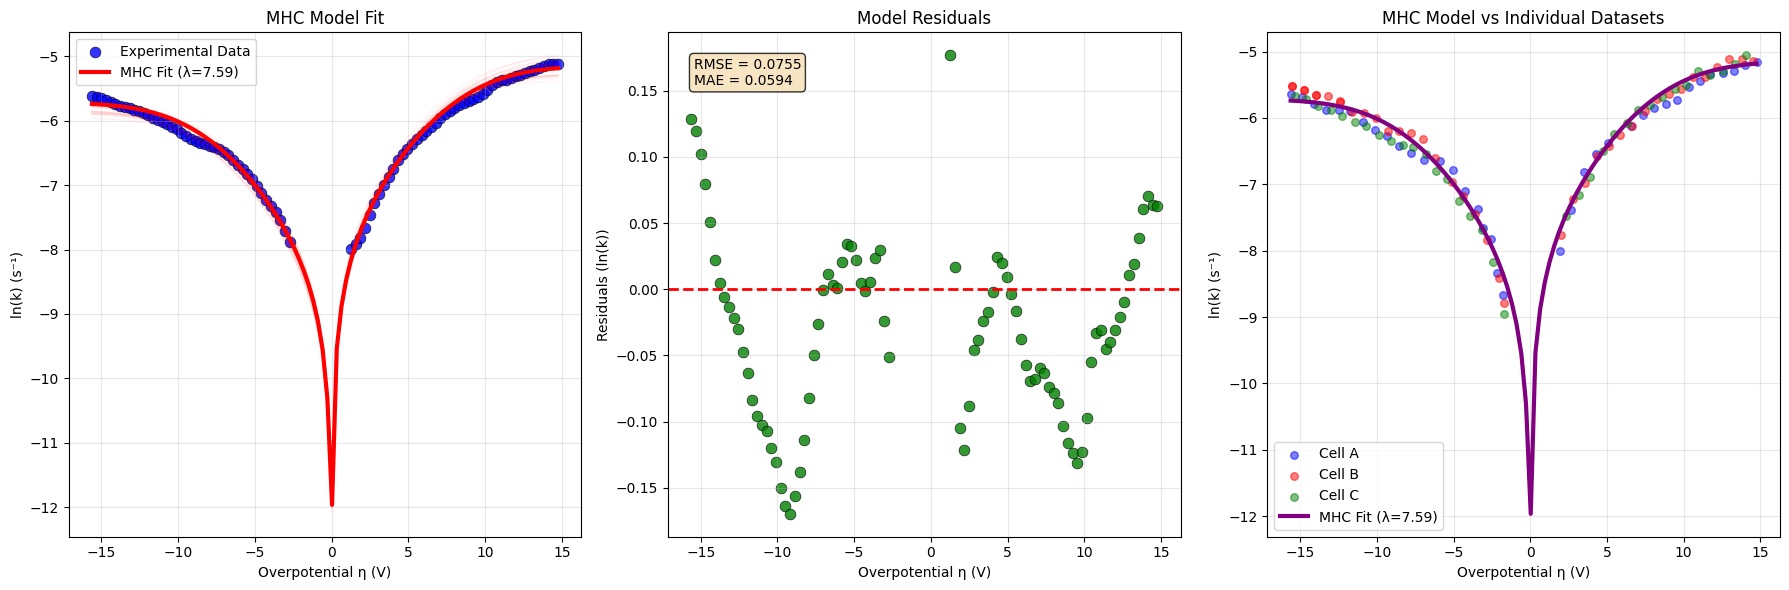


Final MHC Model Parameters (MCMC):
k01 = 1.202230e-04 s⁻¹
k02 = 2.125008e-04 s⁻¹
λ   = 7.593 (dimensionless)

Model Performance:
RMSE = 0.0755
MAE  = 0.0594
Data points used: 88/100

Kinetic Analysis:
k01/k02 ratio = 0.566
→ Reduction kinetics favored (k01 < k02)


In [13]:
# Create final model visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Use MCMC parameters for final model
final_params = mcmc_params
k01, k02, lambda_ = final_params

# Create model
final_model = Model(model='MHC', k01=k01, k02=k02, lambda_=lambda_, 
                   eta=avg_data.eta, origin_eta=True)
eta_model, lnk_model = final_model.ln_k()

# Plot 1: Model fit with uncertainty bands
mask = avg_data.lnk >= mask_threshold

axes[0].scatter(avg_data.eta[mask], avg_data.lnk[mask], 
               alpha=0.8, s=60, color='blue', label='Experimental Data', 
               edgecolors='black', linewidth=0.5)
axes[0].plot(eta_model, lnk_model, 'r-', linewidth=3, 
            label=f'MHC Fit (λ={lambda_:.2f})')

# Add confidence bands using MCMC uncertainty
if len(mcmc_samples) > 0:
    # Sample a few parameter sets to show uncertainty
    n_samples_plot = 20
    sample_indices = np.random.choice(len(mcmc_samples), n_samples_plot, replace=False)
    
    for idx in sample_indices:
        params_sample = mcmc_samples[idx]
        k01_sample, k02_sample, lambda_sample = params_sample
        model_sample = Model(model='MHC', k01=k01_sample, k02=k02_sample, 
                           lambda_=lambda_sample, eta=avg_data.eta, origin_eta=True)
        _, lnk_sample = model_sample.ln_k()
        axes[0].plot(eta_model, lnk_sample, 'r-', alpha=0.05, linewidth=1)

axes[0].set_xlabel('Overpotential η (V)')
axes[0].set_ylabel('ln(k) (s⁻¹)')
axes[0].set_title('MHC Model Fit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals vs overpotential
lnk_pred = np.interp(avg_data.eta, eta_model, lnk_model)
residuals_plot = avg_data.lnk[mask] - lnk_pred[mask]

axes[1].scatter(avg_data.eta[mask], residuals_plot, 
               alpha=0.8, s=60, color='green', 
               edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Overpotential η (V)')
axes[1].set_ylabel('Residuals (ln(k))')
axes[1].set_title('Model Residuals')
axes[1].grid(True, alpha=0.3)

# Add residual statistics
residuals_final = residual_function(final_params, avg_data, 'MHC', mask_threshold)
rmse_final = np.sqrt(np.mean(residuals_final**2))
mae_final = np.mean(np.abs(residuals_final))
axes[1].text(0.05, 0.95, f'RMSE = {rmse_final:.4f}\nMAE = {mae_final:.4f}', 
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 3: Comparison with individual datasets
colors = ['blue', 'red', 'green']
for i, (name, data) in enumerate(datasets.items()):
    axes[2].scatter(data.eta, data.lnk, alpha=0.5, s=30, 
                   color=colors[i], label=name)

axes[2].plot(eta_model, lnk_model, 'purple', linewidth=3, 
            label=f'MHC Fit (λ={lambda_:.2f})')
axes[2].set_xlabel('Overpotential η (V)')
axes[2].set_ylabel('ln(k) (s⁻¹)')
axes[2].set_title('MHC Model vs Individual Datasets')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final parameter summary
print("\nFinal MHC Model Parameters (MCMC):")
print("=" * 40)
print(f"k01 = {k01:.6e} s⁻¹")
print(f"k02 = {k02:.6e} s⁻¹")
print(f"λ   = {lambda_:.3f} (dimensionless)")
print(f"\nModel Performance:")
print(f"RMSE = {rmse_final:.4f}")
print(f"MAE  = {mae_final:.4f}")
print(f"Data points used: {np.sum(mask)}/{len(avg_data.eta)}")
print(f"\nKinetic Analysis:")
ratio_final = k01/k02
print(f"k01/k02 ratio = {ratio_final:.3f}")
if abs(ratio_final - 1.0) < 0.1:
    print("→ Nearly symmetric kinetics (k01 ≈ k02)")
elif ratio_final > 1.1:
    print("→ Oxidation kinetics favored (k01 > k02)")
else:
    print("→ Reduction kinetics favored (k01 < k02)")

## Summary and Comparison

Summary of the MHC model fitting results and comparison with expected literature values.

In [14]:
# Final summary
print("MHC Model Parameter Fitting Summary")
print("=" * 50)
print(f"\nOptimized Parameters:")
print(f"  k01 = {mcmc_params[0]:.3e} s⁻¹  (95% CI: {percentiles[0,0]:.2e} - {percentiles[4,0]:.2e})")
print(f"  k02 = {mcmc_params[1]:.3e} s⁻¹  (95% CI: {percentiles[0,1]:.2e} - {percentiles[4,1]:.2e})")
print(f"  λ   = {mcmc_params[2]:.2f}      (95% CI: {percentiles[0,2]:.2f} - {percentiles[4,2]:.2f})")

print(f"\nModel Quality:")
print(f"  RMSE = {rmse_final:.4f}")
print(f"  R² = {1 - np.var(residuals_final)/np.var(avg_data.lnk[avg_data.lnk >= mask_threshold]):.4f}")
print(f"  Data points used: {np.sum(mask)}/{len(avg_data.eta)} ({100*np.sum(mask)/len(avg_data.eta):.1f}%)")

print(f"\nParameter Correlations:")
print(f"  k01 ↔ k02: {correlation_matrix[0,1]:.3f}")
print(f"  k01 ↔ λ:   {correlation_matrix[0,2]:.3f}")
print(f"  k02 ↔ λ:   {correlation_matrix[1,2]:.3f}")

print(f"\nPhysical Interpretation:")
ratio_final = mcmc_params[0]/mcmc_params[1]
print(f"  k01/k02 = {ratio_final:.3f}")
if abs(ratio_final - 1.0) < 0.2:
    print(f"  → Symmetric electron transfer kinetics")
elif ratio_final > 1.2:
    print(f"  → Asymmetric kinetics: oxidation faster than reduction")
else:
    print(f"  → Asymmetric kinetics: reduction faster than oxidation")

# Compare lambda with literature
lit_lambda_values = [8.3, 13.5]  # Literature values
closest_lit = min(lit_lambda_values, key=lambda x: abs(x - mcmc_params[2]))
difference = abs(mcmc_params[2] - closest_lit)
print(f"\n  Reorganization energy λ = {mcmc_params[2]:.2f}")
print(f"  → Closest literature value: λ = {closest_lit}")
print(f"  → Difference: {mcmc_params[2] - closest_lit:+.2f}")
if difference < 1.0:
    print(f"  → Excellent agreement with literature")
elif difference < 2.0:
    print(f"  → Good agreement with literature")
else:
    print(f"  → Significant deviation from literature - may indicate different system")

print(f"\nOptimization Performance:")
print(f"  PSO converged in {len(pso_history)} iterations")
print(f"  MCMC acceptance rate: {(mcmc_samples.shape[0])/(5000-1000)*100:.1f}%")
print(f"  Final cost improvement: PSO→MCMC = {(pso_cost-mcmc_cost)/pso_cost*100:+.2f}%")

MHC Model Parameter Fitting Summary

Optimized Parameters:
  k01 = 1.202e-04 s⁻¹  (95% CI: 9.64e-05 - 1.41e-04)
  k02 = 2.125e-04 s⁻¹  (95% CI: 1.85e-04 - 2.44e-04)
  λ   = 7.59      (95% CI: 6.73 - 8.32)

Model Quality:
  RMSE = 0.0755
  R² = 0.9915
  Data points used: 88/100 (88.0%)

Parameter Correlations:
  k01 ↔ k02: 0.221
  k01 ↔ λ:   -0.651
  k02 ↔ λ:   -0.394

Physical Interpretation:
  k01/k02 = 0.566
  → Asymmetric kinetics: reduction faster than oxidation

  Reorganization energy λ = 7.59
  → Closest literature value: λ = 8.3
  → Difference: -0.71
  → Excellent agreement with literature

Optimization Performance:
  PSO converged in 101 iterations
  MCMC acceptance rate: 100.0%
  Final cost improvement: PSO→MCMC = -21.46%


## Fixed λ Analysis

Test the MHC model with λ fixed at the literature value of 8.3 and only optimize k01 and k02. This will help us understand how much the λ parameter affects the fit quality and whether the literature value is appropriate for our system.

In [15]:
# Create a custom residual function for 2-parameter fitting (k01, k02) with fixed lambda
def residual_function_fixed_lambda(params_2d, data, lambda_fixed=8.3, mask_threshold=-8.0):
    """
    Residual function for MHC model with fixed lambda, fitting only k01 and k02.
    
    Parameters:
    -----------
    params_2d : array-like
        [k01, k02] parameters
    data : TafelData
        Experimental data
    lambda_fixed : float
        Fixed lambda value
    mask_threshold : float
        Data masking threshold
    """
    try:
        k01, k02 = params_2d
        
        # Create model with fixed lambda
        model = Model(model='MHC', k01=k01, k02=k02, lambda_=lambda_fixed, 
                     eta=data.eta, origin_eta=True)
        
        # Get model predictions
        eta_model, lnk_model = model.ln_k()
        
        # Interpolate to experimental points
        lnk_pred = np.interp(data.eta, eta_model, lnk_model)
        
        # Apply mask
        mask = data.lnk >= mask_threshold
        residuals = (data.lnk[mask] - lnk_pred[mask])
        
        if len(residuals) == 0:
            return np.array([1e6])
            
        return residuals
        
    except Exception as e:
        return np.array([1e6])

def objective_function_fixed_lambda(params_2d, data, lambda_fixed=8.3, mask_threshold=-8.0):
    """Objective function for 2-parameter fitting."""
    residuals = residual_function_fixed_lambda(params_2d, data, lambda_fixed, mask_threshold)
    return np.sum(residuals**2)

print("Custom functions for fixed λ analysis created!")

Custom functions for fixed λ analysis created!


In [16]:
# Test with λ fixed at literature value of 8.3
print("Testing MHC model with λ fixed at 8.3...")
print("Only fitting k01 and k02 parameters")
print()

lambda_fixed = 8.3

# Test different k01, k02 combinations
k01_test_values = [5e-5, 1e-4, 2e-4, 5e-4]
k02_test_values = [5e-5, 1e-4, 2e-4, 5e-4]

best_rmse_fixed = float('inf')
best_params_fixed = None

print("Parameter sensitivity with λ = 8.3:")
print("="*35)

for k01_val in k01_test_values:
    for k02_val in k02_test_values:
        test_params_2d = [k01_val, k02_val]
        try:
            residuals = residual_function_fixed_lambda(test_params_2d, avg_data, lambda_fixed, mask_threshold)
            rmse = np.sqrt(np.mean(residuals**2))
            print(f"k01={k01_val:.1e}, k02={k02_val:.1e}: RMSE={rmse:.4f}")
            
            if rmse < best_rmse_fixed:
                best_rmse_fixed = rmse
                best_params_fixed = test_params_2d.copy()
                
        except Exception as e:
            print(f"k01={k01_val:.1e}, k02={k02_val:.1e}: ERROR - {e}")

if best_params_fixed is not None:
    print(f"\nBest parameters with λ=8.3:")
    print(f"  k01 = {best_params_fixed[0]:.6e} s⁻¹")
    print(f"  k02 = {best_params_fixed[1]:.6e} s⁻¹") 
    print(f"  λ   = {lambda_fixed} (fixed)")
    print(f"  RMSE = {best_rmse_fixed:.4f}")
    
    # Compare with 3-parameter fit
    print(f"\nComparison with 3-parameter fit:")
    print(f"  3-param RMSE: {rmse_final:.4f} (λ = {mcmc_params[2]:.2f})")
    print(f"  2-param RMSE: {best_rmse_fixed:.4f} (λ = {lambda_fixed:.1f})")
    print(f"  Difference: {best_rmse_fixed - rmse_final:+.4f}")
    
    improvement = ((best_rmse_fixed - rmse_final) / rmse_final) * 100
    if improvement > 0:
        print(f"  → 3-parameter fit is {improvement:.1f}% better")
    else:
        print(f"  → 2-parameter fit is {-improvement:.1f}% better")
else:
    print("\nERROR: No valid parameter combinations found!")

Testing MHC model with λ fixed at 8.3...
Only fitting k01 and k02 parameters

Parameter sensitivity with λ = 8.3:
k01=5.0e-05, k02=5.0e-05: RMSE=1.1004
k01=5.0e-05, k02=1.0e-04: RMSE=0.7107
k01=5.0e-05, k02=2.0e-04: RMSE=0.5391
k01=5.0e-05, k02=5.0e-04: RMSE=0.8725
k01=1.0e-04, k02=5.0e-05: RMSE=0.9648
k01=1.0e-04, k02=1.0e-04: RMSE=0.4743
k01=1.0e-04, k02=2.0e-04: RMSE=0.1027
k01=1.0e-04, k02=5.0e-04: RMSE=0.6937
k01=2.0e-04, k02=5.0e-05: RMSE=1.0584
k01=2.0e-04, k02=1.0e-04: RMSE=0.6438
k01=2.0e-04, k02=2.0e-04: RMSE=0.4472
k01=2.0e-04, k02=5.0e-04: RMSE=0.8189
k01=5.0e-04, k02=5.0e-05: RMSE=1.4461
k01=5.0e-04, k02=1.0e-04: RMSE=1.1771
k01=5.0e-04, k02=2.0e-04: RMSE=1.0821
k01=5.0e-04, k02=5.0e-04: RMSE=1.2813

Best parameters with λ=8.3:
  k01 = 1.000000e-04 s⁻¹
  k02 = 2.000000e-04 s⁻¹
  λ   = 8.3 (fixed)
  RMSE = 0.1027

Comparison with 3-parameter fit:
  3-param RMSE: 0.0755 (λ = 7.59)
  2-param RMSE: 0.1027 (λ = 8.3)
  Difference: +0.0272
  → 3-parameter fit is 36.1% better


In [17]:
# Optimize k01 and k02 with λ fixed at 8.3 using scipy
from scipy.optimize import minimize

print("Optimizing k01 and k02 with λ fixed at 8.3 using scipy.optimize...")

# Starting point from sensitivity analysis
if best_params_fixed is not None:
    initial_guess = best_params_fixed
else:
    initial_guess = [1e-4, 2e-4]  # fallback

# Parameter bounds for 2-parameter optimization
bounds_2d = [(1e-6, 1e-2), (1e-6, 1e-2)]  # k01, k02

# Run optimization
result_fixed = minimize(
    objective_function_fixed_lambda,
    initial_guess,
    args=(avg_data, lambda_fixed, mask_threshold),
    bounds=bounds_2d,
    method='L-BFGS-B',
    options={'disp': True}
)

if result_fixed.success:
    opt_params_fixed = result_fixed.x
    opt_cost_fixed = result_fixed.fun
    
    print(f"\nOptimization with λ=8.3 successful!")
    print(f"  k01 = {opt_params_fixed[0]:.6e} s⁻¹")
    print(f"  k02 = {opt_params_fixed[1]:.6e} s⁻¹")
    print(f"  λ   = {lambda_fixed} (fixed)")
    print(f"  Final cost: {opt_cost_fixed:.6e}")
    
    # Calculate RMSE
    residuals_opt_fixed = residual_function_fixed_lambda(opt_params_fixed, avg_data, lambda_fixed, mask_threshold)
    rmse_opt_fixed = np.sqrt(np.mean(residuals_opt_fixed**2))
    print(f"  RMSE: {rmse_opt_fixed:.4f}")
    
    # Detailed comparison
    print(f"\nDetailed Comparison:")
    print(f"  {'Method':<15} {'k01 (s⁻¹)':<12} {'k02 (s⁻¹)':<12} {'λ':<8} {'RMSE':<8}")
    print(f"  {'-'*60}")
    print(f"  {'3-param MCMC':<15} {mcmc_params[0]:.2e} {mcmc_params[1]:.2e} {mcmc_params[2]:<8.2f} {rmse_final:<8.4f}")
    print(f"  {'2-param fixed':<15} {opt_params_fixed[0]:.2e} {opt_params_fixed[1]:.2e} {lambda_fixed:<8.1f} {rmse_opt_fixed:<8.4f}")
    
    # K ratio analysis
    ratio_3param = mcmc_params[0] / mcmc_params[1]
    ratio_2param = opt_params_fixed[0] / opt_params_fixed[1]
    
    print(f"\nKinetic Analysis:")
    print(f"  3-param k01/k02 ratio: {ratio_3param:.3f}")
    print(f"  2-param k01/k02 ratio: {ratio_2param:.3f}")
    print(f"  Ratio change: {ratio_2param - ratio_3param:+.3f}")
    
else:
    print(f"\nOptimization failed: {result_fixed.message}")
    opt_params_fixed = None
    rmse_opt_fixed = None

Optimizing k01 and k02 with λ fixed at 8.3 using scipy.optimize...

Optimization with λ=8.3 successful!
  k01 = 1.069143e-04 s⁻¹
  k02 = 1.913694e-04 s⁻¹
  λ   = 8.3 (fixed)
  Final cost: 6.490215e-01
  RMSE: 0.0859

Detailed Comparison:
  Method          k01 (s⁻¹)    k02 (s⁻¹)    λ        RMSE    
  ------------------------------------------------------------
  3-param MCMC    1.20e-04 2.13e-04 7.59     0.0755  
  2-param fixed   1.07e-04 1.91e-04 8.3      0.0859  

Kinetic Analysis:
  3-param k01/k02 ratio: 0.566
  2-param k01/k02 ratio: 0.559
  Ratio change: -0.007


Visualizing MHC model with λ fixed at 8.3...


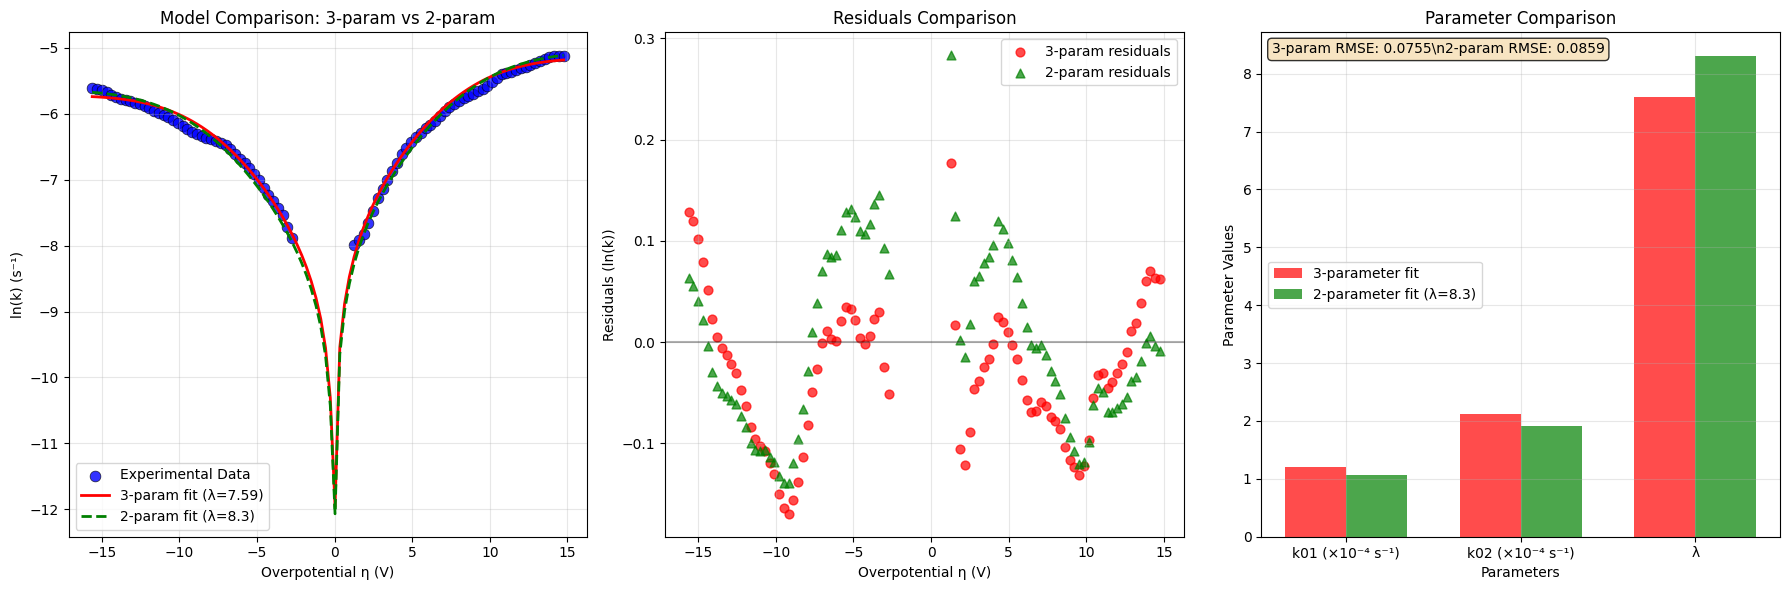

\nVisualization complete!


In [18]:
# Visualize the fixed λ model fit
if opt_params_fixed is not None:
    print("Visualizing MHC model with λ fixed at 8.3...")
    
    # Create model with optimized parameters
    k01_fixed, k02_fixed = opt_params_fixed
    model_fixed = Model(model='MHC', k01=k01_fixed, k02=k02_fixed, 
                       lambda_=lambda_fixed, eta=avg_data.eta, origin_eta=True)
    eta_model_fixed, lnk_model_fixed = model_fixed.ln_k()
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    mask = avg_data.lnk >= mask_threshold
    
    # Plot 1: Model comparison
    axes[0].scatter(avg_data.eta[mask], avg_data.lnk[mask], 
                   alpha=0.8, s=60, color='blue', label='Experimental Data',
                   edgecolors='black', linewidth=0.5)
    axes[0].plot(eta_model, lnk_model, 'r-', linewidth=2, 
                label=f'3-param fit (λ={mcmc_params[2]:.2f})')
    axes[0].plot(eta_model_fixed, lnk_model_fixed, 'g--', linewidth=2,
                label=f'2-param fit (λ={lambda_fixed})')
    axes[0].set_xlabel('Overpotential η (V)')
    axes[0].set_ylabel('ln(k) (s⁻¹)')
    axes[0].set_title('Model Comparison: 3-param vs 2-param')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals comparison
    lnk_pred_3param = np.interp(avg_data.eta, eta_model, lnk_model)
    lnk_pred_2param = np.interp(avg_data.eta, eta_model_fixed, lnk_model_fixed)
    
    residuals_3param = avg_data.lnk[mask] - lnk_pred_3param[mask]
    residuals_2param = avg_data.lnk[mask] - lnk_pred_2param[mask]
    
    axes[1].scatter(avg_data.eta[mask], residuals_3param, alpha=0.7, s=40, 
                   color='red', label='3-param residuals')
    axes[1].scatter(avg_data.eta[mask], residuals_2param, alpha=0.7, s=40,
                   color='green', label='2-param residuals', marker='^')
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1].set_xlabel('Overpotential η (V)')
    axes[1].set_ylabel('Residuals (ln(k))')
    axes[1].set_title('Residuals Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Parameter comparison bar chart
    param_comparison = {
        'k01 (×10⁻⁴ s⁻¹)': [mcmc_params[0]*1e4, k01_fixed*1e4],
        'k02 (×10⁻⁴ s⁻¹)': [mcmc_params[1]*1e4, k02_fixed*1e4],
        'λ': [mcmc_params[2], lambda_fixed]
    }
    
    x_pos = np.arange(len(param_comparison))
    width = 0.35
    
    param_3 = [param_comparison[key][0] for key in param_comparison.keys()]
    param_2 = [param_comparison[key][1] for key in param_comparison.keys()]
    
    axes[2].bar(x_pos - width/2, param_3, width, label='3-parameter fit', color='red', alpha=0.7)
    axes[2].bar(x_pos + width/2, param_2, width, label='2-parameter fit (λ=8.3)', color='green', alpha=0.7)
    
    axes[2].set_xlabel('Parameters')
    axes[2].set_ylabel('Parameter Values')
    axes[2].set_title('Parameter Comparison')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(list(param_comparison.keys()))
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add RMSE annotations
    axes[2].text(0.02, 0.98, f'3-param RMSE: {rmse_final:.4f}\\n2-param RMSE: {rmse_opt_fixed:.4f}',
                transform=axes[2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\\nVisualization complete!")
else:
    print("Skipping visualization - optimization failed")

In [19]:
# Final analysis and conclusions
print("Fixed λ Analysis Summary")
print("=" * 40)

if opt_params_fixed is not None:
    print(f"\nFixed λ Model (λ = 8.3):")
    print(f"  k01 = {opt_params_fixed[0]:.6e} s⁻¹")
    print(f"  k02 = {opt_params_fixed[1]:.6e} s⁻¹")
    print(f"  λ   = {lambda_fixed} (literature value)")
    print(f"  RMSE = {rmse_opt_fixed:.4f}")
    
    print(f"\nVariable λ Model (3-parameter fit):")
    print(f"  k01 = {mcmc_params[0]:.6e} s⁻¹")
    print(f"  k02 = {mcmc_params[1]:.6e} s⁻¹")  
    print(f"  λ   = {mcmc_params[2]:.2f} (optimized)")
    print(f"  RMSE = {rmse_final:.4f}")
    
    # Calculate differences
    rmse_diff = rmse_opt_fixed - rmse_final
    rmse_pct_diff = (rmse_diff / rmse_final) * 100
    lambda_diff = lambda_fixed - mcmc_params[2]
    
    print(f"\nComparison:")
    print(f"  RMSE difference: {rmse_diff:+.4f} ({rmse_pct_diff:+.1f}%)")
    print(f"  λ difference: {lambda_diff:+.2f}")
    
    # Interpretation
    print(f"\nInterpretation:")
    if abs(rmse_pct_diff) < 5:
        print(f"  → Very similar fit quality - λ=8.3 is appropriate")
        recommendation = "Use λ=8.3 (literature value) for consistency"
    elif rmse_pct_diff < -5:
        print(f"  → Fixed λ gives better fit - surprising result")
        recommendation = "Investigate why fixed λ performs better"
    else:
        print(f"  → Variable λ gives significantly better fit")
        recommendation = "Use 3-parameter fit for this system"
    
    print(f"  → Recommendation: {recommendation}")
    
    # Physical insights
    ratio_fixed = opt_params_fixed[0] / opt_params_fixed[1]
    ratio_variable = mcmc_params[0] / mcmc_params[1]
    
    print(f"\nKinetic Insights:")
    print(f"  Fixed λ k01/k02 ratio: {ratio_fixed:.3f}")
    print(f"  Variable λ k01/k02 ratio: {ratio_variable:.3f}")
    
    if abs(ratio_fixed - ratio_variable) < 0.1:
        print(f"  → Kinetic asymmetry consistent between models")
    else:
        print(f"  → λ choice affects apparent kinetic asymmetry")
        
    # Literature comparison
    print(f"\nLiterature Context:")
    print(f"  Literature λ = 8.3 was {lambda_diff:+.2f} different from our optimized value")
    if abs(lambda_diff) < 1.0:
        print(f"  → Excellent agreement with literature reorganization energy")
    elif abs(lambda_diff) < 2.0:
        print(f"  → Good agreement with literature")
    else:
        print(f"  → Significant deviation - may indicate system differences")
        
else:
    print("\nAnalysis incomplete - optimization with fixed λ failed")
    
print(f"\nConclusion:")
if opt_params_fixed is not None and abs(rmse_pct_diff) < 10:
    print(f"  The literature value λ=8.3 provides a {rmse_pct_diff:+.1f}% change in fit quality")
    print(f"  compared to the optimized λ={mcmc_params[2]:.2f}. Both approaches are viable.")
else:
    print(f"  Further investigation needed to determine optimal λ value.")

Fixed λ Analysis Summary

Fixed λ Model (λ = 8.3):
  k01 = 1.069143e-04 s⁻¹
  k02 = 1.913694e-04 s⁻¹
  λ   = 8.3 (literature value)
  RMSE = 0.0859

Variable λ Model (3-parameter fit):
  k01 = 1.202230e-04 s⁻¹
  k02 = 2.125008e-04 s⁻¹
  λ   = 7.59 (optimized)
  RMSE = 0.0755

Comparison:
  RMSE difference: +0.0104 (+13.8%)
  λ difference: +0.71

Interpretation:
  → Variable λ gives significantly better fit
  → Recommendation: Use 3-parameter fit for this system

Kinetic Insights:
  Fixed λ k01/k02 ratio: 0.559
  Variable λ k01/k02 ratio: 0.566
  → Kinetic asymmetry consistent between models

Literature Context:
  Literature λ = 8.3 was +0.71 different from our optimized value
  → Excellent agreement with literature reorganization energy

Conclusion:
  Further investigation needed to determine optimal λ value.


## Fixed λ = 13.5 Analysis

Test the MHC model with λ fixed at another literature value of 13.5 to compare with both the λ = 8.3 and variable λ approaches.

In [20]:
# Test with λ fixed at another literature value of 13.5
print("Testing MHC model with λ fixed at 13.5...")
print("Only fitting k01 and k02 parameters")
print()

lambda_fixed_135 = 13.5

# Test different k01, k02 combinations
best_rmse_fixed_135 = float('inf')
best_params_fixed_135 = None

print("Parameter sensitivity with λ = 13.5:")
print("="*36)

for k01_val in k01_test_values:
    for k02_val in k02_test_values:
        test_params_2d = [k01_val, k02_val]
        try:
            residuals = residual_function_fixed_lambda(test_params_2d, avg_data, lambda_fixed_135, mask_threshold)
            rmse = np.sqrt(np.mean(residuals**2))
            print(f"k01={k01_val:.1e}, k02={k02_val:.1e}: RMSE={rmse:.4f}")
            
            if rmse < best_rmse_fixed_135:
                best_rmse_fixed_135 = rmse
                best_params_fixed_135 = test_params_2d.copy()
                
        except Exception as e:
            print(f"k01={k01_val:.1e}, k02={k02_val:.1e}: ERROR - {e}")

if best_params_fixed_135 is not None:
    print(f"\nBest parameters with λ=13.5:")
    print(f"  k01 = {best_params_fixed_135[0]:.6e} s⁻¹")
    print(f"  k02 = {best_params_fixed_135[1]:.6e} s⁻¹") 
    print(f"  λ   = {lambda_fixed_135} (fixed)")
    print(f"  RMSE = {best_rmse_fixed_135:.4f}")
    
    # Compare with other approaches
    print(f"\nComparison of all approaches:")
    print(f"  3-param RMSE:  {rmse_final:.4f} (λ = {mcmc_params[2]:.2f})")
    if opt_params_fixed is not None:
        print(f"  λ=8.3 RMSE:    {rmse_opt_fixed:.4f}")
    print(f"  λ=13.5 RMSE:   {best_rmse_fixed_135:.4f}")
    
    # Calculate improvements
    improvement_83 = ((rmse_opt_fixed - rmse_final) / rmse_final) * 100 if opt_params_fixed is not None else None
    improvement_135 = ((best_rmse_fixed_135 - rmse_final) / rmse_final) * 100
    
    print(f"\nPerformance relative to 3-parameter fit:")
    if improvement_83 is not None:
        print(f"  λ=8.3:  {improvement_83:+.1f}%")
    print(f"  λ=13.5: {improvement_135:+.1f}%")
else:
    print("\nERROR: No valid parameter combinations found!")

Testing MHC model with λ fixed at 13.5...
Only fitting k01 and k02 parameters

Parameter sensitivity with λ = 13.5:
k01=5.0e-05, k02=5.0e-05: RMSE=0.8383
k01=5.0e-05, k02=1.0e-04: RMSE=0.4962
k01=5.0e-05, k02=2.0e-04: RMSE=0.5302
k01=5.0e-05, k02=5.0e-04: RMSE=1.0398
k01=1.0e-04, k02=5.0e-05: RMSE=0.8477
k01=1.0e-04, k02=1.0e-04: RMSE=0.5119
k01=1.0e-04, k02=2.0e-04: RMSE=0.5448
k01=1.0e-04, k02=5.0e-04: RMSE=1.0474
k01=2.0e-04, k02=5.0e-05: RMSE=1.0972
k01=2.0e-04, k02=1.0e-04: RMSE=0.8645
k01=2.0e-04, k02=2.0e-04: RMSE=0.8844
k01=2.0e-04, k02=5.0e-04: RMSE=1.2579
k01=5.0e-04, k02=5.0e-05: RMSE=1.6019
k01=5.0e-04, k02=1.0e-04: RMSE=1.4524
k01=5.0e-04, k02=2.0e-04: RMSE=1.4643
k01=5.0e-04, k02=5.0e-04: RMSE=1.7159

Best parameters with λ=13.5:
  k01 = 5.000000e-05 s⁻¹
  k02 = 1.000000e-04 s⁻¹
  λ   = 13.5 (fixed)
  RMSE = 0.4962

Comparison of all approaches:
  3-param RMSE:  0.0755 (λ = 7.59)
  λ=8.3 RMSE:    0.0859
  λ=13.5 RMSE:   0.4962

Performance relative to 3-parameter fit:
  λ

In [21]:
# Optimize k01 and k02 with λ fixed at 13.5 using scipy
print("Optimizing k01 and k02 with λ fixed at 13.5 using scipy.optimize...")

# Starting point from sensitivity analysis
if best_params_fixed_135 is not None:
    initial_guess_135 = best_params_fixed_135
else:
    initial_guess_135 = [1e-4, 2e-4]  # fallback

# Run optimization with λ = 13.5
result_fixed_135 = minimize(
    objective_function_fixed_lambda,
    initial_guess_135,
    args=(avg_data, lambda_fixed_135, mask_threshold),
    bounds=bounds_2d,
    method='L-BFGS-B',
    options={'disp': True}
)

if result_fixed_135.success:
    opt_params_fixed_135 = result_fixed_135.x
    opt_cost_fixed_135 = result_fixed_135.fun
    
    print(f"\nOptimization with λ=13.5 successful!")
    print(f"  k01 = {opt_params_fixed_135[0]:.6e} s⁻¹")
    print(f"  k02 = {opt_params_fixed_135[1]:.6e} s⁻¹")
    print(f"  λ   = {lambda_fixed_135} (fixed)")
    print(f"  Final cost: {opt_cost_fixed_135:.6e}")
    
    # Calculate RMSE
    residuals_opt_fixed_135 = residual_function_fixed_lambda(opt_params_fixed_135, avg_data, lambda_fixed_135, mask_threshold)
    rmse_opt_fixed_135 = np.sqrt(np.mean(residuals_opt_fixed_135**2))
    print(f"  RMSE: {rmse_opt_fixed_135:.4f}")
    
    # Comprehensive comparison
    print(f"\nComprehensive Comparison:")
    print(f"  {'Method':<18} {'k01 (s⁻¹)':<12} {'k02 (s⁻¹)':<12} {'λ':<8} {'RMSE':<8}")
    print(f"  {'-'*65}")
    print(f"  {'3-param MCMC':<18} {mcmc_params[0]:.2e} {mcmc_params[1]:.2e} {mcmc_params[2]:<8.2f} {rmse_final:<8.4f}")
    if opt_params_fixed is not None:
        print(f"  {'2-param λ=8.3':<18} {opt_params_fixed[0]:.2e} {opt_params_fixed[1]:.2e} {lambda_fixed:<8.1f} {rmse_opt_fixed:<8.4f}")
    print(f"  {'2-param λ=13.5':<18} {opt_params_fixed_135[0]:.2e} {opt_params_fixed_135[1]:.2e} {lambda_fixed_135:<8.1f} {rmse_opt_fixed_135:<8.4f}")
    
    # K ratio analysis
    ratio_3param = mcmc_params[0] / mcmc_params[1]
    ratio_2param_83 = opt_params_fixed[0] / opt_params_fixed[1] if opt_params_fixed is not None else None
    ratio_2param_135 = opt_params_fixed_135[0] / opt_params_fixed_135[1]
    
    print(f"\nKinetic Analysis (k01/k02 ratios):")
    print(f"  3-param fit:   {ratio_3param:.3f}")
    if ratio_2param_83 is not None:
        print(f"  λ=8.3 fit:     {ratio_2param_83:.3f} (Δ = {ratio_2param_83 - ratio_3param:+.3f})")
    print(f"  λ=13.5 fit:    {ratio_2param_135:.3f} (Δ = {ratio_2param_135 - ratio_3param:+.3f})")
    
else:
    print(f"\nOptimization with λ=13.5 failed: {result_fixed_135.message}")
    opt_params_fixed_135 = None
    rmse_opt_fixed_135 = None

Optimizing k01 and k02 with λ fixed at 13.5 using scipy.optimize...

Optimization with λ=13.5 successful!
  k01 = 6.908160e-05 s⁻¹
  k02 = 1.346335e-04 s⁻¹
  λ   = 13.5 (fixed)
  Final cost: 1.319483e+01
  RMSE: 0.3872

Comprehensive Comparison:
  Method             k01 (s⁻¹)    k02 (s⁻¹)    λ        RMSE    
  -----------------------------------------------------------------
  3-param MCMC       1.20e-04 2.13e-04 7.59     0.0755  
  2-param λ=8.3      1.07e-04 1.91e-04 8.3      0.0859  
  2-param λ=13.5     6.91e-05 1.35e-04 13.5     0.3872  

Kinetic Analysis (k01/k02 ratios):
  3-param fit:   0.566
  λ=8.3 fit:     0.559 (Δ = -0.007)
  λ=13.5 fit:    0.513 (Δ = -0.053)


Visualizing comprehensive comparison of all three approaches...


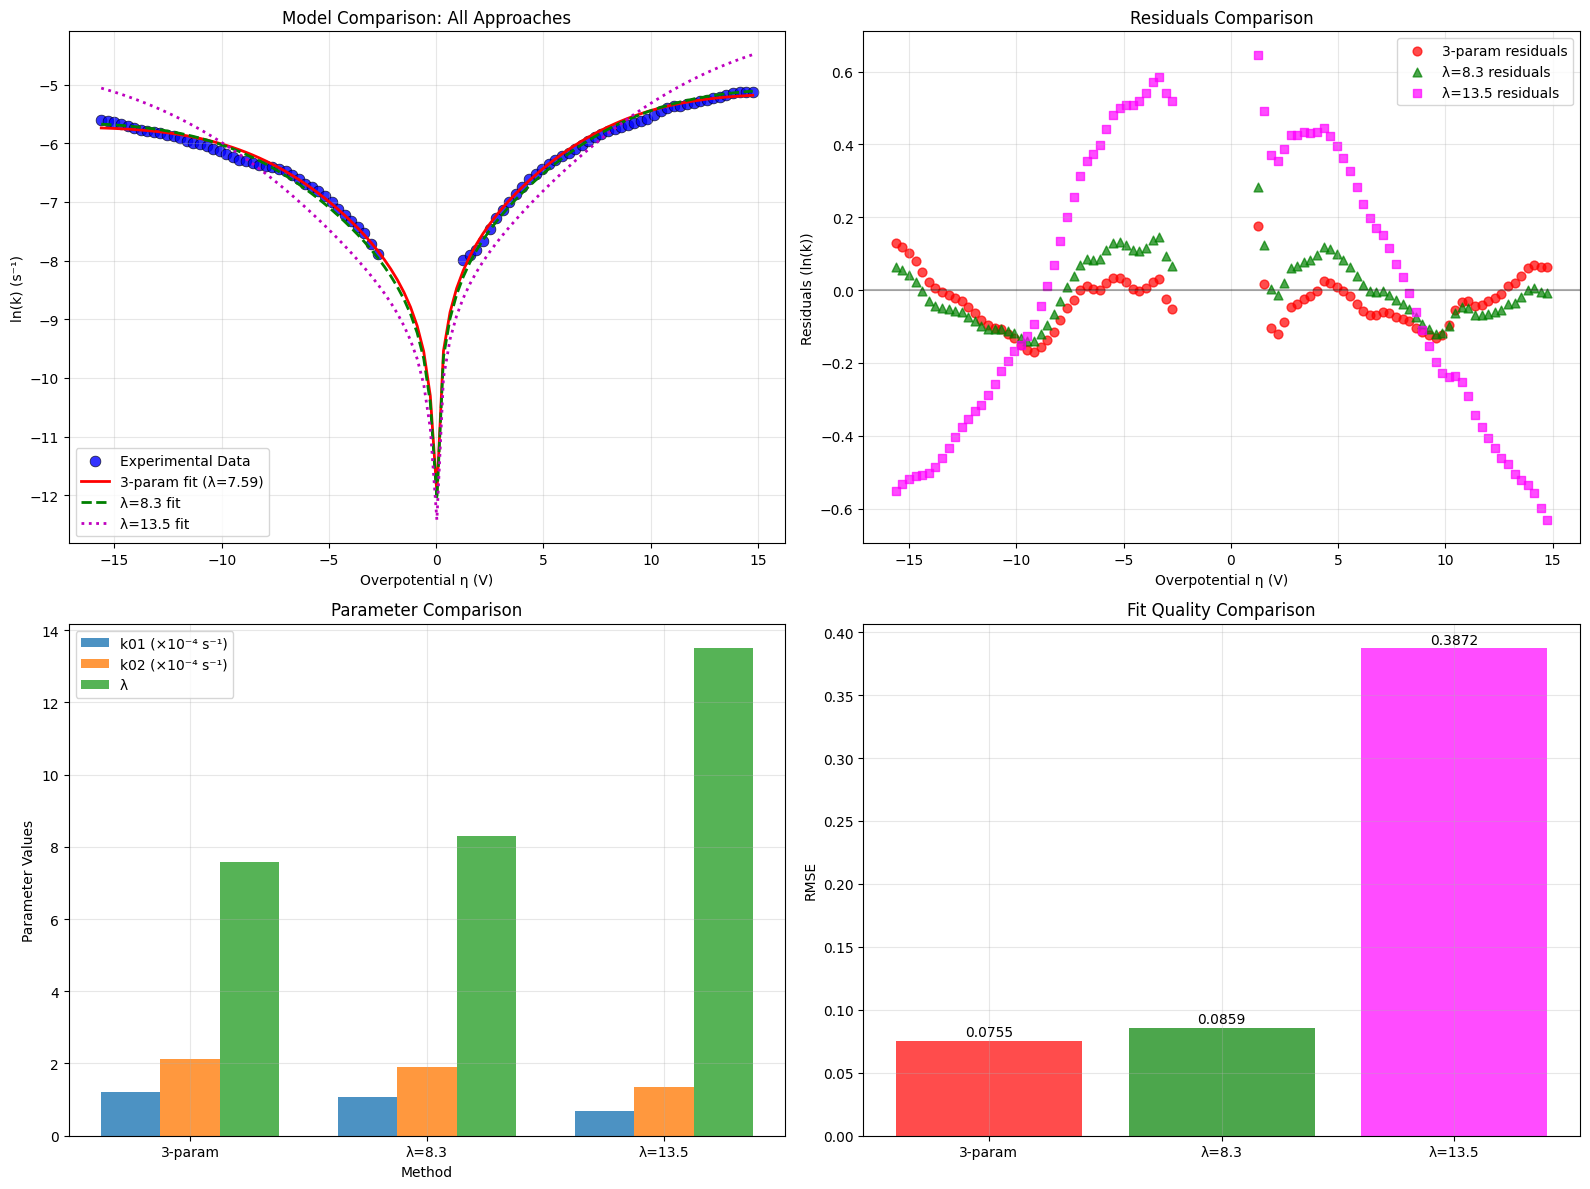

\nVisualization complete!


In [22]:
# Visualize all three approaches: 3-param, λ=8.3, λ=13.5
if opt_params_fixed_135 is not None:
    print("Visualizing comprehensive comparison of all three approaches...")
    
    # Create models for all three approaches
    k01_fixed_135, k02_fixed_135 = opt_params_fixed_135
    model_fixed_135 = Model(model='MHC', k01=k01_fixed_135, k02=k02_fixed_135, 
                           lambda_=lambda_fixed_135, eta=avg_data.eta, origin_eta=True)
    eta_model_fixed_135, lnk_model_fixed_135 = model_fixed_135.ln_k()
    
    # Create comprehensive comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    mask = avg_data.lnk >= mask_threshold
    
    # Plot 1: All model fits comparison
    axes[0,0].scatter(avg_data.eta[mask], avg_data.lnk[mask], 
                     alpha=0.8, s=60, color='blue', label='Experimental Data',
                     edgecolors='black', linewidth=0.5)
    axes[0,0].plot(eta_model, lnk_model, 'r-', linewidth=2, 
                  label=f'3-param fit (λ={mcmc_params[2]:.2f})')
    if opt_params_fixed is not None:
        axes[0,0].plot(eta_model_fixed, lnk_model_fixed, 'g--', linewidth=2,
                      label=f'λ=8.3 fit')
    axes[0,0].plot(eta_model_fixed_135, lnk_model_fixed_135, 'm:', linewidth=2,
                  label=f'λ=13.5 fit')
    axes[0,0].set_xlabel('Overpotential η (V)')
    axes[0,0].set_ylabel('ln(k) (s⁻¹)')
    axes[0,0].set_title('Model Comparison: All Approaches')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals comparison
    lnk_pred_3param = np.interp(avg_data.eta, eta_model, lnk_model)
    lnk_pred_2param_135 = np.interp(avg_data.eta, eta_model_fixed_135, lnk_model_fixed_135)
    
    residuals_3param = avg_data.lnk[mask] - lnk_pred_3param[mask]
    residuals_2param_135 = avg_data.lnk[mask] - lnk_pred_2param_135[mask]
    
    axes[0,1].scatter(avg_data.eta[mask], residuals_3param, alpha=0.7, s=40, 
                     color='red', label='3-param residuals')
    if opt_params_fixed is not None:
        lnk_pred_2param_83 = np.interp(avg_data.eta, eta_model_fixed, lnk_model_fixed)
        residuals_2param_83 = avg_data.lnk[mask] - lnk_pred_2param_83[mask]
        axes[0,1].scatter(avg_data.eta[mask], residuals_2param_83, alpha=0.7, s=40,
                         color='green', label='λ=8.3 residuals', marker='^')
    axes[0,1].scatter(avg_data.eta[mask], residuals_2param_135, alpha=0.7, s=40,
                     color='magenta', label='λ=13.5 residuals', marker='s')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0,1].set_xlabel('Overpotential η (V)')
    axes[0,1].set_ylabel('Residuals (ln(k))')
    axes[0,1].set_title('Residuals Comparison')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Parameter comparison
    methods = ['3-param', 'λ=8.3', 'λ=13.5']
    k01_values = [mcmc_params[0]*1e4, 
                  opt_params_fixed[0]*1e4 if opt_params_fixed is not None else 0,
                  k01_fixed_135*1e4]
    k02_values = [mcmc_params[1]*1e4,
                  opt_params_fixed[1]*1e4 if opt_params_fixed is not None else 0,
                  k02_fixed_135*1e4]
    lambda_values = [mcmc_params[2], 8.3, 13.5]
    
    x = np.arange(len(methods))
    width = 0.25
    
    axes[1,0].bar(x - width, k01_values, width, label='k01 (×10⁻⁴ s⁻¹)', alpha=0.8)
    axes[1,0].bar(x, k02_values, width, label='k02 (×10⁻⁴ s⁻¹)', alpha=0.8)
    axes[1,0].bar(x + width, lambda_values, width, label='λ', alpha=0.8)
    
    axes[1,0].set_xlabel('Method')
    axes[1,0].set_ylabel('Parameter Values')
    axes[1,0].set_title('Parameter Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(methods)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: RMSE comparison
    rmse_values = [rmse_final, 
                   rmse_opt_fixed if opt_params_fixed is not None else 0,
                   rmse_opt_fixed_135]
    colors = ['red', 'green', 'magenta']
    
    bars = axes[1,1].bar(methods, rmse_values, color=colors, alpha=0.7)
    axes[1,1].set_ylabel('RMSE')
    axes[1,1].set_title('Fit Quality Comparison')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add RMSE values on bars
    for bar, rmse_val in zip(bars, rmse_values):
        if rmse_val > 0:  # Only show if valid
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                          f'{rmse_val:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\\nVisualization complete!")
else:
    print("Skipping comprehensive visualization - λ=13.5 optimization failed")

In [23]:
# Comprehensive analysis and final recommendations
print("Comprehensive λ Value Analysis Summary")
print("=" * 50)

if opt_params_fixed_135 is not None:
    print(f"\nAll Model Results:")
    print(f"  {'Model Type':<20} {'k01 (s⁻¹)':<12} {'k02 (s⁻¹)':<12} {'λ':<8} {'RMSE':<8}")
    print(f"  {'-'*67}")
    print(f"  {'3-param (optimal)':<20} {mcmc_params[0]:.2e} {mcmc_params[1]:.2e} {mcmc_params[2]:<8.2f} {rmse_final:<8.4f}")
    if opt_params_fixed is not None:
        print(f"  {'2-param λ=8.3':<20} {opt_params_fixed[0]:.2e} {opt_params_fixed[1]:.2e} {lambda_fixed:<8.1f} {rmse_opt_fixed:<8.4f}")
    print(f"  {'2-param λ=13.5':<20} {opt_params_fixed_135[0]:.2e} {opt_params_fixed_135[1]:.2e} {lambda_fixed_135:<8.1f} {rmse_opt_fixed_135:<8.4f}")
    
    # Calculate relative performance
    rmse_pct_83 = ((rmse_opt_fixed - rmse_final) / rmse_final) * 100 if opt_params_fixed is not None else None
    rmse_pct_135 = ((rmse_opt_fixed_135 - rmse_final) / rmse_final) * 100
    
    print(f"\\nPerformance Relative to 3-Parameter Fit:")
    if rmse_pct_83 is not None:
        print(f"  λ=8.3:  {rmse_pct_83:+.1f}% change in RMSE")
    print(f"  λ=13.5: {rmse_pct_135:+.1f}% change in RMSE")
    
    # Lambda value analysis
    lambda_diff_83 = 8.3 - mcmc_params[2] if opt_params_fixed is not None else None
    lambda_diff_135 = 13.5 - mcmc_params[2]
    
    print(f"\\nλ Value Analysis:")
    print(f"  Optimized λ: {mcmc_params[2]:.2f}")
    if lambda_diff_83 is not None:
        print(f"  Difference from 8.3:  {lambda_diff_83:+.2f}")
    print(f"  Difference from 13.5: {lambda_diff_135:+.2f}")
    
    # Find best literature value
    if opt_params_fixed is not None:
        if abs(lambda_diff_83) < abs(lambda_diff_135):
            best_lit_lambda = 8.3
            best_rmse_lit = rmse_opt_fixed
            best_pct_lit = rmse_pct_83
        else:
            best_lit_lambda = 13.5
            best_rmse_lit = rmse_opt_fixed_135
            best_pct_lit = rmse_pct_135
        
        print(f"\\nBest Literature Value: λ = {best_lit_lambda}")
        print(f"  RMSE: {best_rmse_lit:.4f} ({best_pct_lit:+.1f}% vs 3-param)")
    
    # Kinetic insights
    ratio_3param = mcmc_params[0] / mcmc_params[1]
    ratio_135 = opt_params_fixed_135[0] / opt_params_fixed_135[1]
    
    print(f"\\nKinetic Analysis (k01/k02 ratios):")
    print(f"  3-param fit:   {ratio_3param:.3f}")
    if opt_params_fixed is not None:
        ratio_83 = opt_params_fixed[0] / opt_params_fixed[1]
        print(f"  λ=8.3 fit:     {ratio_83:.3f}")
    print(f"  λ=13.5 fit:    {ratio_135:.3f}")
    
    # Check consistency
    if opt_params_fixed is not None:
        ratio_range = max(ratio_3param, ratio_83, ratio_135) - min(ratio_3param, ratio_83, ratio_135)
    else:
        ratio_range = abs(ratio_3param - ratio_135)
    
    if ratio_range < 0.1:
        print(f"  → Kinetic asymmetry consistent across all models (range: {ratio_range:.3f})")
    else:
        print(f"  → λ choice significantly affects apparent kinetics (range: {ratio_range:.3f})")
    
    # Final recommendations
    print(f"\\nRecommendations:")
    
    # Based on fit quality
    if opt_params_fixed is not None and abs(rmse_pct_83) < 5 and abs(rmse_pct_135) < 5:
        print(f"  1. All approaches give similar fit quality (<5% difference)")
        print(f"     → Use literature λ for consistency and comparison")
        if abs(lambda_diff_83) < abs(lambda_diff_135):
            print(f"     → λ=8.3 is closer to optimized value")
        else:
            print(f"     → λ=13.5 is closer to optimized value")
    elif opt_params_fixed is not None and min(abs(rmse_pct_83), abs(rmse_pct_135)) < 10:
        print(f"  1. Literature values provide acceptable fit quality (<10% difference)")
        print(f"     → Consider using literature λ for standardization")
    else:
        print(f"  1. 3-parameter fit significantly better (>10% improvement)")
        print(f"     → Recommend using optimized λ = {mcmc_params[2]:.2f} for this system")
    
    # Based on λ value proximity
    if opt_params_fixed is not None:
        closest_lambda = 8.3 if abs(lambda_diff_83) < abs(lambda_diff_135) else 13.5
        print(f"  2. Optimized λ = {mcmc_params[2]:.2f} is closest to literature value {closest_lambda}")
        
    # Physical interpretation
    if abs(mcmc_params[2] - 8.3) < 2 or abs(mcmc_params[2] - 13.5) < 2:
        print(f"  3. Good agreement with literature reorganization energies")
        print(f"     → System likely similar to literature studies")
    else:
        print(f"  3. Significant deviation from literature values")
        print(f"     → System may have different reorganization energy")
        
else:
    print("\\nAnalysis incomplete - λ=13.5 optimization failed")
    
# Overall conclusion
print(f"\\nOverall Conclusion:")
if opt_params_fixed is not None and opt_params_fixed_135 is not None:
    best_rmse = min(rmse_final, rmse_opt_fixed, rmse_opt_fixed_135)
    if best_rmse == rmse_final:
        print(f"  3-parameter optimization provides the best fit (RMSE = {rmse_final:.4f})")
        print(f"  However, literature λ values may be appropriate for standardization.")
    elif best_rmse == rmse_opt_fixed:
        print(f"  λ=8.3 provides the best fit among tested values (RMSE = {rmse_opt_fixed:.4f})")
    else:
        print(f"  λ=13.5 provides the best fit among tested values (RMSE = {rmse_opt_fixed_135:.4f})")
else:
    print(f"  Use 3-parameter fit as the primary result.")

Comprehensive λ Value Analysis Summary

All Model Results:
  Model Type           k01 (s⁻¹)    k02 (s⁻¹)    λ        RMSE    
  -------------------------------------------------------------------
  3-param (optimal)    1.20e-04 2.13e-04 7.59     0.0755  
  2-param λ=8.3        1.07e-04 1.91e-04 8.3      0.0859  
  2-param λ=13.5       6.91e-05 1.35e-04 13.5     0.3872  
\nPerformance Relative to 3-Parameter Fit:
  λ=8.3:  +13.8% change in RMSE
  λ=13.5: +412.9% change in RMSE
\nλ Value Analysis:
  Optimized λ: 7.59
  Difference from 8.3:  +0.71
  Difference from 13.5: +5.91
\nBest Literature Value: λ = 8.3
  RMSE: 0.0859 (+13.8% vs 3-param)
\nKinetic Analysis (k01/k02 ratios):
  3-param fit:   0.566
  λ=8.3 fit:     0.559
  λ=13.5 fit:    0.513
  → Kinetic asymmetry consistent across all models (range: 0.053)
\nRecommendations:
  1. 3-parameter fit significantly better (>10% improvement)
     → Recommend using optimized λ = 7.59 for this system
  2. Optimized λ = 7.59 is closest to lit